# 02 - Data Preprocessing: CICIDS2017 Dataset

This notebook handles data cleaning, transformation, and preparation for model training.

## Objectives:
1. Load raw dataset
2. Clean data (remove duplicates, handle missing values)
3. Handle infinite and outlier values
4. Feature selection and engineering
5. Label encoding
6. Data normalization/standardization
7. Train-test split
8. Handle class imbalance
9. Save processed data

## 1. Setup and Imports

In [2]:
# Add parent directory to path
import sys
sys.path.append('..')

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import yaml
import joblib
import os

# Scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Custom module
from src.data_processing import DataProcessor

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Initialize Data Processor

In [4]:
# Initialize processor
processor = DataProcessor(config_path='../config/config.yaml')

print("✓ Data processor initialized")
print(f"\nConfiguration:")
print(f"  Raw data path: {processor.config['paths']['data_raw']}")
print(f"  Processed data path: {processor.config['paths']['data_processed']}")
print(f"  Normalization method: {processor.config['preprocessing']['normalization']}")
print(f"  Sampling method: {processor.config['preprocessing']['sampling']['method']}")

INFO:src.data_processing:Configuration loaded from ../config/config.yaml


✓ Data processor initialized

Configuration:
  Raw data path: data/raw/
  Processed data path: data/processed/
  Normalization method: standard
  Sampling method: SMOTE


## 3. Load Dataset

For this notebook, we'll use a sample of the data for faster processing.

In [5]:
import os

RAW_PATH = "../data/raw"

print("Absolute path:", os.path.abspath(RAW_PATH))
print("Exists:", os.path.exists(RAW_PATH))
print("Files found:")
for f in os.listdir(RAW_PATH):
    print(" -", f)


Absolute path: c:\Users\ghada\intrusion-detection-system\data\raw
Exists: True
Files found:
 - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 - Friday-WorkingHours-Morning.pcap_ISCX.csv
 - Monday-WorkingHours.pcap_ISCX.csv
 - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
 - Tuesday-WorkingHours.pcap_ISCX.csv
 - Wednesday-workingHours.pcap_ISCX.csv


In [6]:
import pandas as pd

data1 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv(r'C:\Users\ghada\intrusion-detection-system\data\raw\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')


In [7]:
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 529918 rows, 79 columns
Data2 -> 445909 rows, 79 columns
Data3 -> 692703 rows, 79 columns
Data4 -> 170366 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 191033 rows, 79 columns
Data7 -> 286467 rows, 79 columns
Data8 -> 225745 rows, 79 columns


In [8]:
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [9]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

In [11]:

print(f"\n✓ Dataset loaded successfully")
print(f"  Shape: {df.shape}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


✓ Dataset loaded successfully


NameError: name 'df' is not defined

In [12]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [13]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

## 4. Initial Data Quality Check

In [15]:
pd.options.display.max_rows = 80

print('Overview of Columns:')
data.describe().transpose()

Overview of Columns:


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-1.300000e+01,155.000000,31316.000000,3.204828e+06,1.200000e+08
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.000000e+00,2.000000,2.000000,5.000000e+00,2.197590e+05
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.000000e+00,1.000000,2.000000,4.000000e+00,2.919220e+05
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.000000e+00,12.000000,62.000000,1.870000e+02,1.290000e+07
Total Length of Bwd Packets,2830743.0,1.616264e+04,2.263088e+06,0.000000e+00,0.000000,123.000000,4.820000e+02,6.554530e+08
Fwd Packet Length Max,2830743.0,2.075999e+02,7.171848e+02,0.000000e+00,6.000000,37.000000,8.100000e+01,2.482000e+04
Fwd Packet Length Min,2830743.0,1.871366e+01,6.033935e+01,0.000000e+00,0.000000,2.000000,3.600000e+01,2.325000e+03
Fwd Packet Length Mean,2830743.0,5.820194e+01,1.860912e+02,0.000000e+00,6.000000,34.000000,5.000000e+01,5.940857e+03
Fwd Packet Length Std,2830743.0,6.891013e+01,2.811871e+02,0.000000e+00,0.000000,0.000000,2.616295e+01,7.125597e+03


In [16]:
pd.options.display.max_columns = 80
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,3.000000e+06,5.000000e+05,4.0,0.0,4,4,4,4.0,0.0,4,4,0,0.0,0.0,0,0,0,0,0,0,40,0,5.000000e+05,0.00000,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,1.200000e+07,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.00000,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,1.200000e+07,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.00000,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,1.200000e+07,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.00000,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,6.666667e+05,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,6.666667e+05,0.00000,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,3.278689e+04,61.0,0.0,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,1.639344e+04,16393.44262,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.666667e+05,2.777778e+04,72.0,0.0,72,72,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,1.388889e+04,13888.88889,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.600000e+05,2.666667e+04,75.0,0.0,75,75,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,1.333333e+04,13333.33333,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,2.500000e+05,4.166667e+04,48.0,0.0,48,48,48,48.0,0.0,48,48,0,0.0,0.0,0,0,0,0,0,0,40,0,4.166667e+04,0.00000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,4719,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## 5. Data Cleaning

In [17]:
dups = data[data.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 308381


In [18]:
data.drop_duplicates(inplace = True)
data.shape

(2522362, 79)

In [19]:
missing_val = data.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    353
dtype: int64


In [20]:
# Checking for infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [21]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3128


In [22]:
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [23]:
# Calculating missing value percentage in the dataset
mis_per = (missing / len(data)) * 100
mis_table = pd.concat([missing, mis_per.round(2)], axis = 1)
mis_table = mis_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage of Total Values'})

print(mis_table.loc[mis_per > 0])

                Missing Values  Percentage of Total Values
Flow Bytes/s              1564                        0.06
Flow Packets/s            1564                        0.06


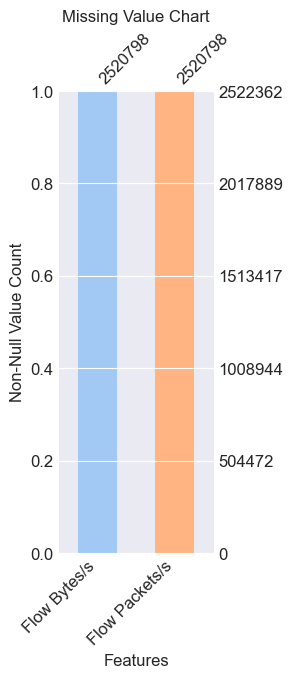

In [24]:
import missingno as msno

sns.set_palette('pastel')
colors = sns.color_palette()

missing_vals = [col for col in data.columns if data[col].isna().any()]

fig, ax = plt.subplots(figsize = (2, 6))
msno.bar(data[missing_vals], ax = ax, fontsize = 12, color = colors)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Non-Null Value Count', fontsize = 12)
ax.set_title('Missing Value Chart', fontsize = 12)
plt.show()

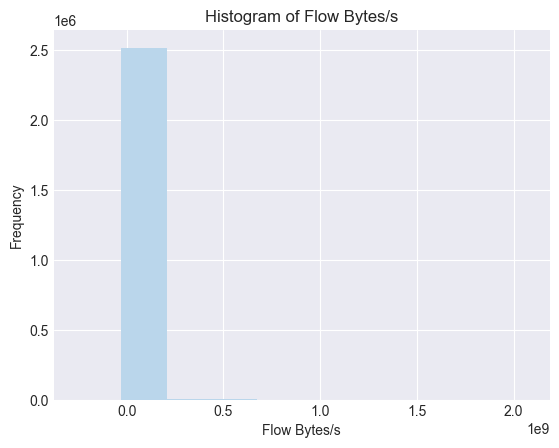

In [25]:
colors = sns.color_palette('Blues')
plt.hist(data['Flow Bytes/s'], color = colors[1])
plt.title('Histogram of Flow Bytes/s')
plt.xlabel('Flow Bytes/s')
plt.ylabel('Frequency')
plt.show()

In [26]:
import numpy as np

data['Flow Bytes/s'] = pd.to_numeric(
    data['Flow Bytes/s'],
    errors='coerce'
)

data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [27]:
flow_bytes = data['Flow Bytes/s'].dropna()


In [28]:
flow_bytes = flow_bytes.reset_index(drop=True)


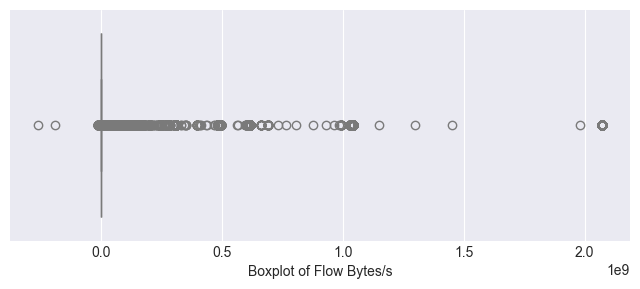

In [29]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=flow_bytes)
plt.xlabel('Boxplot of Flow Bytes/s')
plt.show()


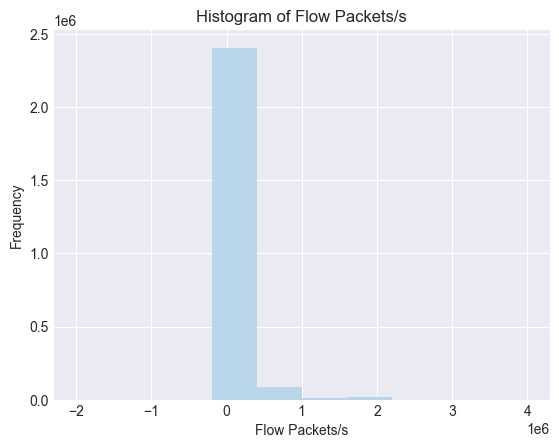

In [30]:
plt.hist(data['Flow Packets/s'], color = colors[1])
plt.title('Histogram of Flow Packets/s')
plt.xlabel('Flow Packets/s')
plt.ylabel('Frequency')
plt.show()

In [31]:
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  3715.0378579999997
Median of Flow Packets/s:  69.742244285


In [32]:
# Filling missing values with median
data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

In [33]:
print('Number of \'Flow Bytes/s\' missing values:', data['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', data['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


2.3 Analysing Patterns using Visualisations

#### Visualization of column correlation. Also, plotting Heat Map

In [34]:
data['Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

In [35]:
# Types of attacks & normal instances (BENIGN)
data['Label'].value_counts()

Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [36]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

In [37]:
data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [38]:
data.drop('Label', axis = 1, inplace = True)

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

print(data['Attack Number'].unique())

[0 2 4 5 8 6 1 7 3]


In [40]:
# Printing corresponding attack type for each encoded value
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Bot
2: Brute Force
3: DDoS
4: DoS
5: Heartbleed
6: Infiltration
7: Port Scan
8: Web Attack


## 7. Label Encoding

In [43]:
print("\n=== Step 3: Label Encoding ===")

# Choose encoding type
BINARY_CLASSIFICATION = True  # Set to True for binary, False for multi-class

print(f"Classification type: {'Binary' if BINARY_CLASSIFICATION else 'Multi-class'}")

# Select label column
label_col = 'Attack Type'

# Create binary labels if needed
if BINARY_CLASSIFICATION:
    y = data[label_col].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')
else:
    y = data[label_col]

# Encode labels using your processor
y_encoded = processor.encode_labels(y, binary=BINARY_CLASSIFICATION)

print(f"\n✓ Labels encoded")
print(f"  Unique labels: {len(np.unique(y_encoded))}")
print(f"  Label range: [{y_encoded.min()}, {y_encoded.max()}]")

# Show mapping only for multi-class
if not BINARY_CLASSIFICATION:
    print(f"\nLabel mapping:")
    for idx, label in enumerate(processor.label_encoder.classes_):
        print(f"  {idx}: {label}")


INFO:src.data_processing:Encoding labels...



=== Step 3: Label Encoding ===
Classification type: Binary


INFO:src.data_processing:Binary encoding: BENIGN=0, ATTACK=1



✓ Labels encoded
  Unique labels: 2
  Label range: [0, 1]


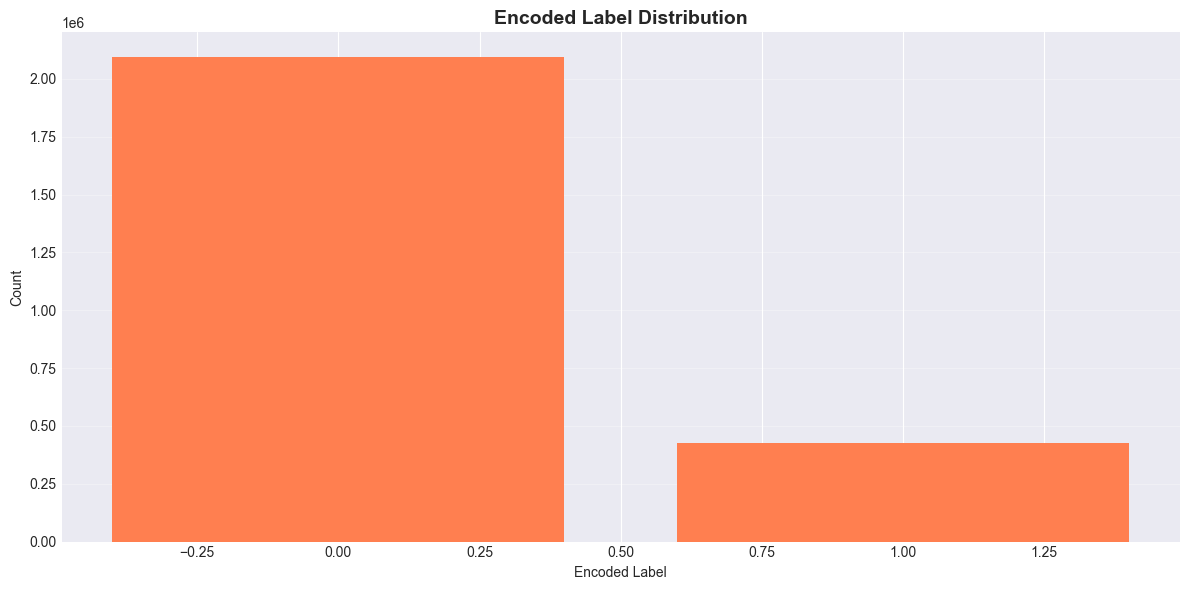


Encoded label distribution:
  Label 0: 2,096,484 (83.12%)
  Label 1: 425,878 (16.88%)


In [45]:
# Visualize encoded label distribution
plt.figure(figsize=(12, 6))
unique, counts = np.unique(y_encoded, return_counts=True)
plt.bar(unique, counts, color='coral')
plt.title('Encoded Label Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Encoded Label')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Class distribution
print("\nEncoded label distribution:")
for label, count in zip(unique, counts):
    percentage = (count / len(y_encoded)) * 100
    print(f"  Label {label}: {count:,} ({percentage:.2f}%)")

In [46]:
print(data.columns.tolist())


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [47]:
# Count per attack type
class_counts = data['Attack Type'].value_counts()
print("Class distribution:")
print(class_counts)

# Percentage
class_percent = (class_counts / class_counts.sum() * 100).round(2)
print("\nClass distribution (%):")
print(class_percent)

# Imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")


Class distribution:
Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

Class distribution (%):
Attack Type
BENIGN          83.12
DoS              7.68
DDoS             5.08
Port Scan        3.60
Brute Force      0.36
Web Attack       0.08
Bot              0.08
Infiltration     0.00
Heartbleed       0.00
Name: count, dtype: float64

Imbalance ratio: 190589.45:1


In [48]:
data['BinaryLabel'] = data['Attack Type'].apply(
    lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK'
)

print("\nBinary class distribution:")
print(data['BinaryLabel'].value_counts())



Binary class distribution:
BinaryLabel
BENIGN    2096484
ATTACK     425878
Name: count, dtype: int64


## 8. Train-Validation-Test Split

In [49]:
# Ensure X and y are aligned
data_clean = data.copy()

# Select features (all numeric columns except label columns)
feature_cols = data_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
X = data_clean[feature_cols]

# Select target
y = data_clean['BinaryLabel']  # or 'Attack Type' for multi-class

# Drop rows with NaNs or inf in X or y
import numpy as np
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Convert to numpy
X = X.values
y_encoded = processor.encode_labels(y, binary=True)  # or False for multi-class

print(f"X shape: {X.shape}")
print(f"y shape: {y_encoded.shape}")


INFO:src.data_processing:Encoding labels...
INFO:src.data_processing:Binary encoding: BENIGN=0, ATTACK=1


X shape: (2522362, 78)
y shape: (2522362,)


In [50]:
X_train, X_val, X_test, y_train, y_val, y_test = processor.split_data(X, y_encoded)

print(f"\nSplit sizes:")
print(f"  Training:   {len(X_train):,}")
print(f"  Validation: {len(X_val):,}")
print(f"  Test:       {len(X_test):,}")


INFO:src.data_processing:Splitting data...
INFO:src.data_processing:Train set: 1765652 samples
INFO:src.data_processing:Validation set: 252237 samples
INFO:src.data_processing:Test set: 504473 samples



Split sizes:
  Training:   1,765,652
  Validation: 252,237
  Test:       504,473


In [51]:
# Verify stratification
print("\nLabel distribution across splits:")
print(f"\nTraining set:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nValidation set:")
print(pd.Series(y_val).value_counts().sort_index())
print(f"\nTest set:")
print(pd.Series(y_test).value_counts().sort_index())


Label distribution across splits:

Training set:
BinaryLabel
0    1467538
1     298114
Name: count, dtype: int64

Validation set:
BinaryLabel
0    209649
1     42588
Name: count, dtype: int64

Test set:
BinaryLabel
0    419297
1     85176
Name: count, dtype: int64


## 9. Feature Normalization

In [52]:
print("\n=== Step 5: Feature Normalization ===")

# Before normalization - show statistics
print("\nBefore normalization (training set):")
print(f"  Mean: {X_train.mean().mean():.3f}")
print(f"  Std:  {X_train.std().mean():.3f}")
print(f"  Min:  {X_train.min().min():.3f}")
print(f"  Max:  {X_train.max().max():.3f}")

# Normalize
X_train_scaled, X_val_scaled = processor.normalize_features(X_train, X_val)
_, X_test_scaled = processor.normalize_features(X_train, X_test)

print(f"\n✓ Normalization complete")
print(f"  Method: {processor.config['preprocessing']['normalization']}")

# After normalization
print("\nAfter normalization (training set):")
print(f"  Mean: {X_train_scaled.mean():.3f}")
print(f"  Std:  {X_train_scaled.std():.3f}")
print(f"  Min:  {X_train_scaled.min():.3f}")
print(f"  Max:  {X_train_scaled.max():.3f}")


=== Step 5: Feature Normalization ===

Before normalization (training set):
  Mean: 1511338.605
  Std:  11004187.790
  Min:  -9663668122.000


INFO:src.data_processing:Normalizing features...


  Max:  2071000000.000


INFO:src.data_processing:Normalization completed using standard scaling
INFO:src.data_processing:Normalizing features...
INFO:src.data_processing:Normalization completed using standard scaling



✓ Normalization complete
  Method: standard

After normalization (training set):
  Mean: 0.000
  Std:  0.947
  Min:  -975.619
  Max:  1077.012


In [55]:
feature_names = [f'feature_{i}' for i in range(X.shape[1])]


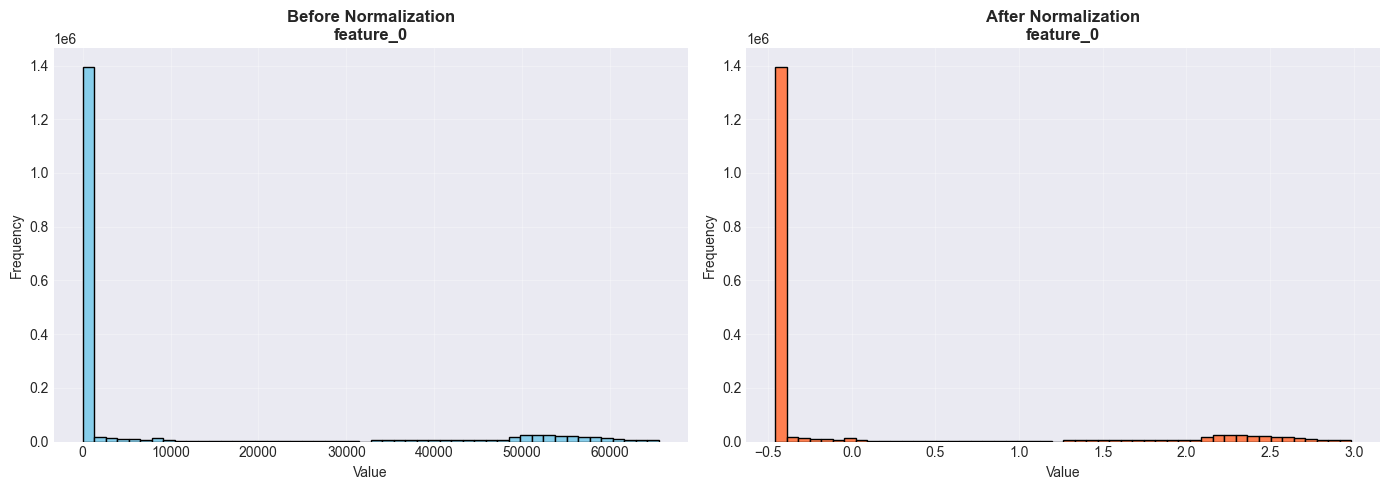

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before normalization
sample_feature_idx = 0
axes[0].hist(X_train[:, sample_feature_idx], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title(f'Before Normalization\n{feature_names[sample_feature_idx]}', fontweight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# After normalization
axes[1].hist(X_train_scaled[:, sample_feature_idx], bins=50, color='coral', edgecolor='black')
axes[1].set_title(f'After Normalization\n{feature_names[sample_feature_idx]}', fontweight='bold')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Handle Class Imbalance

In [57]:
print("\n=== Step 6: Handling Class Imbalance ===")

# Show imbalance before
print("\nClass distribution before resampling:")
unique_before, counts_before = np.unique(y_train, return_counts=True)
for label, count in zip(unique_before, counts_before):
    print(f"  Label {label}: {count:,}")

# Calculate imbalance ratio
imbalance_ratio = counts_before.max() / counts_before.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

# Apply resampling
X_train_resampled, y_train_resampled = processor.handle_imbalance(X_train_scaled, y_train)

# Show distribution after
print("\nClass distribution after resampling:")
unique_after, counts_after = np.unique(y_train_resampled, return_counts=True)
for label, count in zip(unique_after, counts_after):
    print(f"  Label {label}: {count:,}")

print(f"\n✓ Resampling complete")
print(f"  Original training samples: {len(y_train):,}")
print(f"  After resampling: {len(y_train_resampled):,}")
print(f"  Samples added: {len(y_train_resampled) - len(y_train):,}")

INFO:src.data_processing:Handling class imbalance...
INFO:src.data_processing:Original distribution: [1467538  298114]



=== Step 6: Handling Class Imbalance ===

Class distribution before resampling:
  Label 0: 1,467,538
  Label 1: 298,114

Imbalance ratio: 4.92:1


INFO:src.data_processing:Resampled distribution: [1467538 1467538]
INFO:src.data_processing:New training size: 2935076



Class distribution after resampling:
  Label 0: 1,467,538
  Label 1: 1,467,538

✓ Resampling complete
  Original training samples: 1,765,652
  After resampling: 2,935,076
  Samples added: 1,169,424


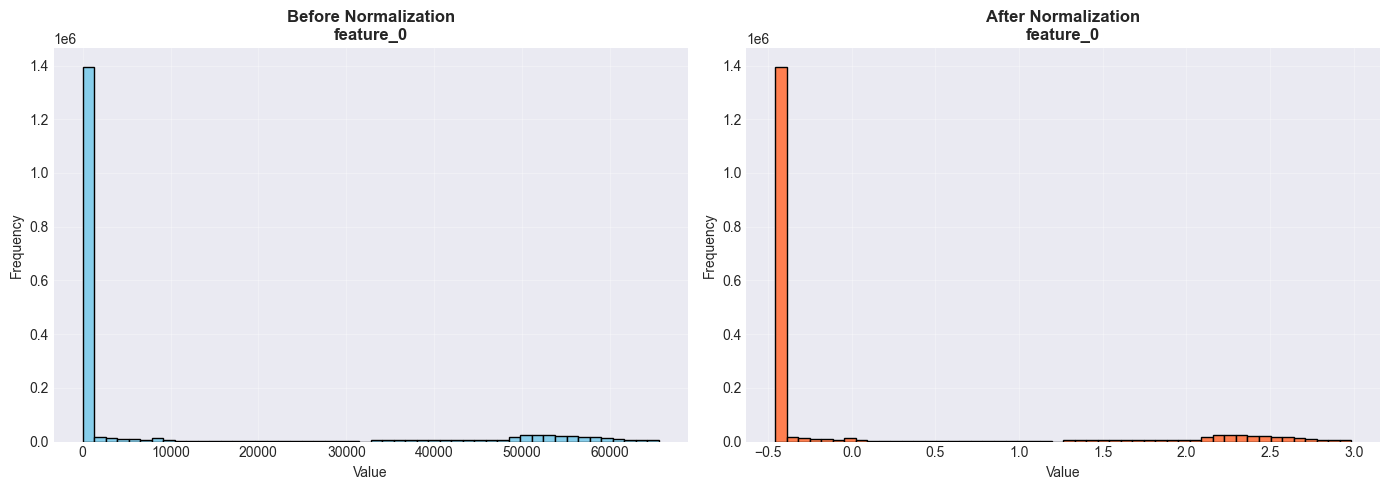

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before normalization
sample_feature_idx = 0
axes[0].hist(X_train[:, sample_feature_idx], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title(f'Before Normalization\n{feature_names[sample_feature_idx]}', fontweight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# After normalization
axes[1].hist(X_train_scaled[:, sample_feature_idx], bins=50, color='coral', edgecolor='black')
axes[1].set_title(f'After Normalization\n{feature_names[sample_feature_idx]}', fontweight='bold')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Save Processed Data

In [59]:
print("\n=== Step 7: Saving Processed Data ===")

# Create processed directory if it doesn't exist
processed_path = processor.config['paths']['data_processed']
os.makedirs(processed_path, exist_ok=True)

# Save all data
processor.save_processed_data(
    X_train_resampled, X_val_scaled, X_test_scaled,
    y_train_resampled, y_val, y_test,
    feature_names
)

print("\n✓ All data saved successfully!")

INFO:src.data_processing:Saving processed data...



=== Step 7: Saving Processed Data ===


INFO:src.data_processing:Data saved to data/processed/



✓ All data saved successfully!


In [60]:
# Verify saved files
print("\nSaved files:")
for file in Path(processed_path).glob('*'):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  ✓ {file.name} ({size_mb:.2f} MB)")


Saved files:
  ✓ feature_names.pkl (0.00 MB)
  ✓ label_encoder.pkl (0.00 MB)
  ✓ scaler.pkl (0.00 MB)
  ✓ X_test.npy (300.21 MB)
  ✓ X_train.npy (1746.64 MB)
  ✓ X_val.npy (150.10 MB)
  ✓ y_test.npy (1.92 MB)
  ✓ y_train.npy (11.20 MB)
  ✓ y_val.npy (0.96 MB)


## 12. Summary Statistics

In [61]:
print("\n" + "="*70)
print("DATA PREPROCESSING - SUMMARY")
print("="*70)

print(f"\n📊 Final Dataset Shapes:")
print(f"  Training:   X={X_train_resampled.shape}, y={y_train_resampled.shape}")
print(f"  Validation: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"  Test:       X={X_test_scaled.shape}, y={y_test.shape}")

print(f"\n🔧 Preprocessing Steps Applied:")
print(f"  ✓ Data cleaning (duplicates, missing values, infinites)")
print(f"  ✓ Feature selection ({len(feature_names)} features retained)")
print(f"  ✓ Label encoding ({'Binary' if BINARY_CLASSIFICATION else 'Multi-class'})")
print(f"  ✓ Train-validation-test split")
print(f"  ✓ Feature normalization ({processor.config['preprocessing']['normalization']})")
print(f"  ✓ Class imbalance handling ({processor.config['preprocessing']['sampling']['method']})")

print(f"\n📁 Files Saved to: {processed_path}")
print(f"  ✓ X_train.npy, X_val.npy, X_test.npy")
print(f"  ✓ y_train.npy, y_val.npy, y_test.npy")
print(f"  ✓ scaler.pkl")
print(f"  ✓ label_encoder.pkl")
print(f"  ✓ feature_names.pkl")

print(f"\n📈 Class Distribution (Final Training Set):")
for label, count in zip(unique_after, counts_after):
    percentage = (count / len(y_train_resampled)) * 100
    if not BINARY_CLASSIFICATION and hasattr(processor.label_encoder, 'classes_'):
        label_name = processor.label_encoder.classes_[label]
        print(f"  {label_name}: {count:,} ({percentage:.2f}%)")
    else:
        print(f"  Label {label}: {count:,} ({percentage:.2f}%)")

print(f"\n✅ Data preprocessing complete!")
print(f"\n📝 Next Steps:")
print(f"  1. Run 03_feature_engineering.ipynb for feature selection")
print(f"  2. Run 04_model_training.ipynb to train ML models")
print(f"  3. Run 05_model_evaluation.ipynb to evaluate performance")

print("\n" + "="*70)


DATA PREPROCESSING - SUMMARY

📊 Final Dataset Shapes:
  Training:   X=(2935076, 78), y=(2935076,)
  Validation: X=(252237, 78), y=(252237,)
  Test:       X=(504473, 78), y=(504473,)

🔧 Preprocessing Steps Applied:
  ✓ Data cleaning (duplicates, missing values, infinites)
  ✓ Feature selection (78 features retained)
  ✓ Label encoding (Binary)
  ✓ Train-validation-test split
  ✓ Feature normalization (standard)
  ✓ Class imbalance handling (SMOTE)

📁 Files Saved to: data/processed/
  ✓ X_train.npy, X_val.npy, X_test.npy
  ✓ y_train.npy, y_val.npy, y_test.npy
  ✓ scaler.pkl
  ✓ label_encoder.pkl
  ✓ feature_names.pkl

📈 Class Distribution (Final Training Set):
  Label 0: 1,467,538 (50.00%)
  Label 1: 1,467,538 (50.00%)

✅ Data preprocessing complete!

📝 Next Steps:
  1. Run 03_feature_engineering.ipynb for feature selection
  2. Run 04_model_training.ipynb to train ML models
  3. Run 05_model_evaluation.ipynb to evaluate performance



## 13. Optional: Test Loading Processed Data

In [ ]:
# Test loading the saved data
print("\n=== Testing Data Loading ===")

# Load processed data
X_train_loaded, X_val_loaded, X_test_loaded, y_train_loaded, y_val_loaded, y_test_loaded = processor.load_processed_data()

print("\n✓ Data loaded successfully")
print(f"\nLoaded shapes:")
print(f"  X_train: {X_train_loaded.shape}")
print(f"  X_val: {X_val_loaded.shape}")
print(f"  X_test: {X_test_loaded.shape}")

# Verify data integrity
print(f"\nData integrity check:")
print(f"  Training data match: {np.array_equal(X_train_resampled, X_train_loaded)}")
print(f"  Validation data match: {np.array_equal(X_val_scaled, X_val_loaded)}")
print(f"  Test data match: {np.array_equal(X_test_scaled, X_test_loaded)}")

# Load feature names
loaded_features = joblib.load(os.path.join(processed_path, 'feature_names.pkl'))
print(f"\n✓ Feature names loaded: {len(loaded_features)} features")